# Read images and labels from LMDBs made by SSD

### Load necessary libs and set up caffe/caffe_root

In [1]:
# Make sure that caffe is on the python path:
#caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
caffe_root = '/work/caffe'
voc_labelmap_file = 'data/VOC0712/labelmap_voc.prototxt'
# LMDB directory name. Inside this directory there are data.mdb and lock.mdb
lmdb_dir = '/work/caffe/examples/VOC0712/VOC0712_test_lmdb'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

### Load LabelMap and define get_labelname function

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
file = open(voc_labelmap_file, 'r')
voc_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), voc_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

### Define functions to read LMDB image/labels from LMDB values

In [3]:
'''
Breakdown of what val(ue) contains from SSD's lmdb files:
- 8 bytes of...something
- JPEG (starts with \xff\xd8, ends at \xff\xd9)
- image tags

The below functions are mostly needed to parse lmdb label data. 
I haven't figured out the format exactly, but I have annotated
one example below from VOC0712 data:

    (begin tags)
    28ffffffffffffffffff0138011000
    (begin label 1)
    1a 1e 08
    (label: \x10 = 16 = 'pottedplant')
    10
    (begin bounding boxes)
    (      0th box:   xmin        ymin        xmax        ymax)
    121a08 00 1216 0d ee7cbf3e 15 ec51b83e 1d 4e62103f 25 9134253f 3000
    (end label 1)
    (begin label 2)
    1a 1e 08
    (label: \x0b = 11 = 'diningtable')
    0b
    (      0th box:   xmin        ymin        xmax        ymax)
    121a08 00 1216 0d 2db29d3e 15 66ad0e3f 1d 91ed3c3f 25 0000803f 3000
    (end label 2)
    (begin label 3)
    1a aa01 08
    (label: \x09 = 9 = 'chair')
    09
    (      0th box:   xmin        ymin        xmax        ymax)
    121a08 00 1216 0d 5c8f023f 15 df4f0d3f 1d 5a643b3f 25 0000803f 3000
    (      1st box:   xmin        ymin        xmax        ymax)
    121a08 01 1216 0d 7593183f 15 b81e053f 1d e7fb293f 25 619e283f 3001
    (      2nd box:   xmin        ymin        xmax        ymax)
    121a08 02 1216 0d 17d90e3f 15 e8b4013f 1d 2db21d3f 25 2db21d3f 3001
    (      3rd box:   xmin        ymin        xmax        ymax)
    121a08 03 1216 0d ba498c3e 15 6f12033f 1d be9f9a3e 25 c5d9073f 3001
    (      4th box:   xmin        ymin        xmax        ymax)
    121a08 04 1216 0d ba498c3e 15 022b073f 1d 77be9f3e 25 afb9103f 3001
    (      5th box:   xmin        ymin        xmax        ymax)
    121a08 05 1216 0d df4f8d3e 15 ec0a103f 1d dbf9fe3e 25 0000803f 3000
    (end tags)
'''
def get_tags(val):
    # create label/bounding box arrays
    labels = []
    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    
    # find beginning of tags
    stream = StringIO.StringIO(val)
    match = re.search('\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\x38\x01\x10\x00', stream.read())

    # go to start of tags
    stream.seek(match.end())

    while tag_has_another_label(stream):

        label = get_next_label(stream)

        while label_has_another_box(stream):
            xmin, ymin, xmax, ymax = get_bounding_box(stream)            
            labels.append(label)
            xmins.append(xmin)
            ymins.append(ymin)
            xmaxs.append(xmax)
            ymaxs.append(ymax)
    
    return labels, xmins, ymins, xmaxs, ymaxs

def label_has_another_box(stream):
    bits = stream.read(2)
    if(len(bits) == 2 and struct.unpack('H', bits)[0] == 6674):
        stream.seek(-2, 1)
        return True
    else:
        stream.seek(-2, 1)
        return False

def get_next_label(stream):
    label_num = struct.unpack('b', stream.read(1))[0]
    return get_labelname(voc_labelmap, label_num)[0]

def tag_has_another_label(stream):
    bits = stream.read(1)
    if(struct.unpack('b', bits)[0] == 26): # 26 = \x1a
        # go to label
        while struct.unpack('b', stream.read(1))[0] != 8:
            continue
        return True
    else:
        return False

def get_bounding_box(stream):
    to_xmin = 7
    to_next_flt = 1
    to_end = 2    
        
    stream.seek(to_xmin, 1)
    xmin = struct.unpack('f', stream.read(4))[0]

    stream.seek(to_next_flt, 1)
    ymin = struct.unpack('f', stream.read(4))[0]

    stream.seek(to_next_flt, 1)
    xmax = struct.unpack('f', stream.read(4))[0]

    stream.seek(to_next_flt, 1)
    ymax = struct.unpack('f', stream.read(4))[0]
    
    stream.seek(to_end, 1)

    return xmin, ymin, xmax, ymax

def get_image(val):
    img_stream = StringIO.StringIO(val[8:]) 
    return Image.open(img_stream)


def display_image(image, labels, xmins, ymins, xmaxs, ymaxs):
    # plot image
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    plt.cla()
    plt.imshow(image)
    currentAxis = plt.gca()

    # display bounding box
    for i in range(0,len(labels)):
        xmin = int(xmins[i] * image.size[0])
        ymin = int(ymins[i] * image.size[1])
        xmax = int(xmaxs[i] * image.size[0])
        ymax = int(ymaxs[i] * image.size[1])

        name = '%s'%(labels[i])
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[i % len(colors)]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})
        
def num_keys(curs):
    count = 0
    if curs.first():
        count += 1
        while curs.next():
            count += 1
    return count

### Open LMDB file and read specific image/labels given key index

00000000_VOC2007/JPEGImages/000001.jpg


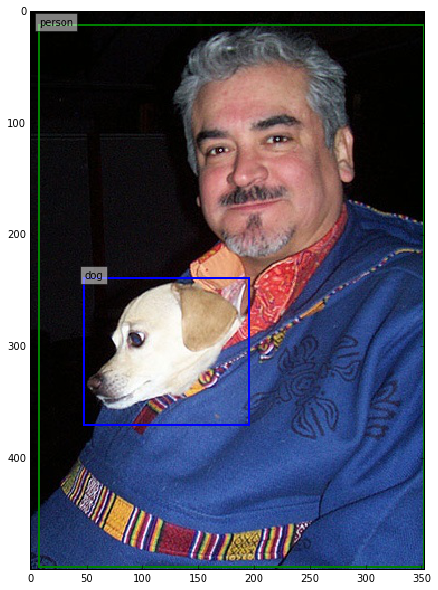

In [4]:
import caffe
import lmdb
import struct
from PIL import Image
import cStringIO as StringIO
import re

# index of image from lmdb file (0 to 4951 for VOC0712)
key_index = 0

env = lmdb.open(lmdb_dir, readonly=True)
with env.begin() as txn:
    with txn.cursor() as curs:
            
#         # Find the total number of key, value pairs
#         print "Total number of key, value pairs: ", str(num_keys(curs))
            
        # get any key/value by number
        curs.first()
        for i in range(0,key_index):
            curs.next()
        key, val = curs.item()
        
        # display key name
        print key
        
        # get tags
        labels, xmins, ymins, xmaxs, ymaxs = get_tags(val)
        
        # get image
        image = get_image(val)

        # draw image
        display_image(image, labels, xmins, ymins, xmaxs, ymaxs)